In [54]:
#----------------------------------
#1. Import Packages & Load Data
#-----------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score
)

#Set global plot style and ensure reproducibility
plt.style.use("seaborn-v0_8")
np.random.seed(42)

#Load Dataset
try:
    s = pd.read_csv("social_media_usage.csv")
    print("Raw shape:", s.shape)
except FileNotFoundError:
    raise FileNotFoundError("The file 'social_media_usage.csv' was not found. Check your working directory.")

##Display first few rows and summary info##
s.head()
s.info()

#Check for missing values and duplicates just in case
print("\nMissing values per column:\n", s.isna().sum())
print("\nNumber of duplicate rows:", s.duplicated().sum())


Raw shape: (1502, 89)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 89 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   respid             1502 non-null   int64  
 1   sample             1502 non-null   int64  
 2   comp               1502 non-null   int64  
 3   int_date           1502 non-null   object 
 4   lang               1502 non-null   int64  
 5   state              1502 non-null   int64  
 6   density            1502 non-null   int64  
 7   usr                1502 non-null   object 
 8   qs1                1502 non-null   object 
 9   sex                1502 non-null   int64  
 10  eminuse            1502 non-null   int64  
 11  intmob             1502 non-null   int64  
 12  intfreq            1502 non-null   object 
 13  snsint2            1502 non-null   int64  
 14  home4nw            1502 non-null   int64  
 15  bbhome1            1502 non-null   object 
 16  bb

In [55]:
#-----------------------------------------
# 2. Define clean_sm Function & Test It
#------------------------------------------

def clean_sm(x):
    """
    Converts a numeric column into binary:
      - returns 1 if value == 1
      - returns 0 otherwise
    Uses np.where for vectorized performance.

    """
    return np.where(x == 1, 1, 0)

# Create a toy dataframe to demonstrate functionality
toy = pd.DataFrame({
    "a": [1, 0, 5],   # column contains valid and invalid values
    "b": [1, 3, 0]
})

# Apply clean_sm to each column in the toy dataframe
toy_cleaned = toy.apply(clean_sm)

print("Original toy dataframe:")
print(toy, "\n")

print("Cleaned toy dataframe (after applying clean_sm):")
print(toy_cleaned)


Original toy dataframe:
   a  b
0  1  1
1  0  3
2  5  0 

Cleaned toy dataframe (after applying clean_sm):
   a  b
0  1  1
1  0  0
2  0  0


In [56]:
#-------------------------------------
# 3. Build cleaned dataframe "ss"
#--------------------------------------------

ss = pd.DataFrame({
    "sm_li": clean_sm(s["web1h"]),  # LinkedIn user (1=yes, 0=no)

    "income": np.where((s["income"] >= 1) & (s["income"] <= 9), s["income"], np.nan),

    "education": np.where((s["educ2"] >= 1) & (s["educ2"] <= 8), s["educ2"], np.nan),

    "parent": clean_sm(s["par"]),

    "married": clean_sm(s["marital"]),

    "female": np.where(s["gender"] == 2, 1, 0),

    "age": np.where((s["age"] >= 1) & (s["age"] <= 97), s["age"], np.nan)
})

# remove missing
ss = ss.dropna()

print("Cleaned dataset shape:", ss.shape)
ss.head()



Cleaned dataset shape: (1260, 7)


,sm_li,income,education,parent,married,female,age
0,0,6.0,4.0,0,0,1,77.0
1,0,5.0,3.0,0,0,0,59.0
2,0,8.0,4.0,0,1,1,60.0
3,0,8.0,8.0,0,0,0,73.0
4,1,7.0,8.0,0,1,1,65.0


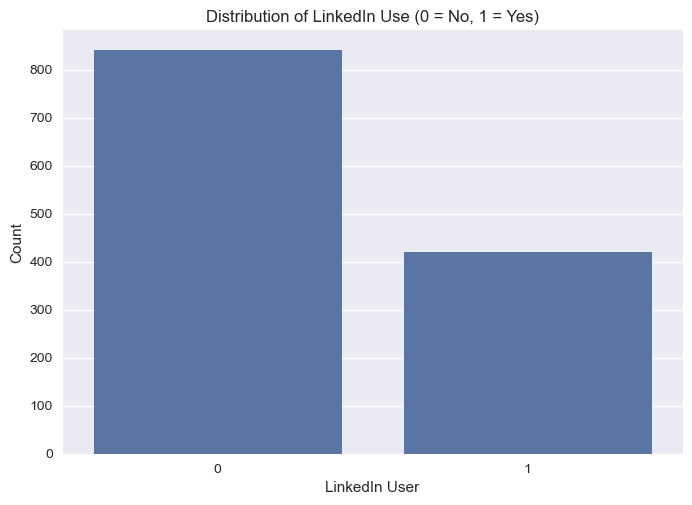

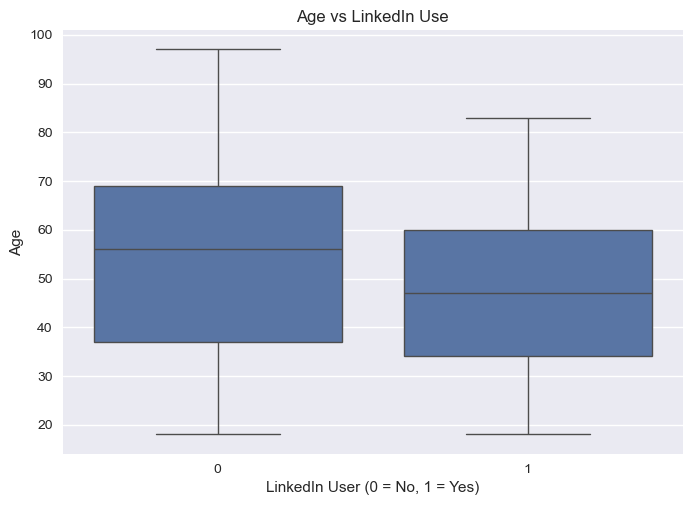

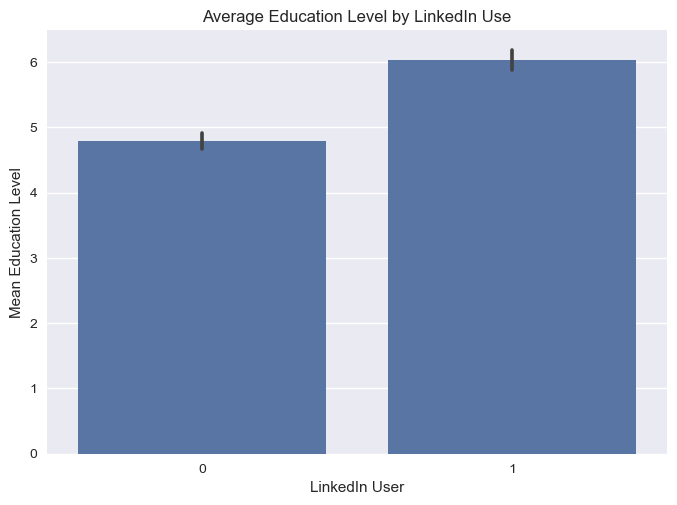

In [57]:
#---------------------------------------------
# Exploratory Analysis
#---------------------------------------------

# Distribution of LinkedIn users
sns.countplot(data=ss, x="sm_li")
plt.title("Distribution of LinkedIn Use (0 = No, 1 = Yes)")
plt.xlabel("LinkedIn User")
plt.ylabel("Count")
plt.show()

# Boxplot: Age vs LinkedIn Use
sns.boxplot(data=ss, x="sm_li", y="age")
plt.title("Age vs LinkedIn Use")
plt.xlabel("LinkedIn User (0 = No, 1 = Yes)")
plt.ylabel("Age")
plt.show()

# Barplot: Average Education by LinkedIn Use
sns.barplot(
    data=ss,
    x="sm_li",
    y="education",
    estimator=np.mean
)
plt.title("Average Education Level by LinkedIn Use")
plt.xlabel("LinkedIn User")
plt.ylabel("Mean Education Level")
plt.show()


In [58]:
##4. Create Target Vector (y) and Feature Matrix (X)##

y = ss["sm_li"]  # target: LinkedIn user (0/1)

X = ss[["income", "education", "parent", "married", "female", "age"]]


print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (1260, 6)
Shape of y: (1260,)


In [59]:
##5. Train/Test Split##

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,     # 20% held out for testing
    random_state=42,    # ensures the split is reproducible
    stratify=y          # keeps LinkedIn-user proportions consistent
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (1008, 6)
Test set size: (252, 6)


## Explain what each new object contains and how it is used in machine learning

- `X_train`: Features used to train the model (80% of the data)
- `X_test`:  Features withheld from training, used to evaluate model performance (20%)

- `y_train`: Target values (LinkedIn user 0/1) corresponding to X_train
- `y_test`:  True target values for X_test, used to measure accuracy, precision, recall, etc.

## Why this is important:
- Machine learning models must be evaluated on data they have never seen before.
- The training set teaches the logistic regression model the relationships between features and the target.
- The test set simulates new, unseen data to measure how well the model generalizes.

---


In [60]:
##6. Train Logistic Regression Model##

lr = LogisticRegression(class_weight="balanced", max_iter=1000)
lr.fit(X_train, y_train)

print("Model training complete.")

# --- SAVE THE MODEL ---
import joblib
joblib.dump(lr, "model.pkl")
print("Model saved as model.pkl")



Model training complete.
Model saved as model.pkl


In this step, I instantiate a logistic regression model and set `class_weight="balanced"` to account for class imbalance in the target variable. Because non-LinkedIn users are more common in the dataset, the model might otherwise learn to always predict the majority class. The balanced setting automatically increases the weight of minority-class observations so the model pays equal attention to both groups. After defining the model, I fit it using the training set so it can learn the relationship between each feature and the likelihood of LinkedIn use.

---

In [61]:
##7 & 8. Model Evaluation and Confusion Matrix

# Predict LinkedIn use on the test set
y_pred = lr.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=["Actual: Non-user (0)", "Actual: User (1)"],
    columns=["Predicted: Non-user (0)", "Predicted: User (1)"]
)
cm_df


Model Accuracy: 0.6468253968253969


,Predicted: Non-user (0),Predicted: User (1)
Actual: Non-user (0),104,64
Actual: User (1),25,59


## Explain what each new object contains and how it is used in machine learning

- `True Negative (TN)`: The number of individuals who do not use LinkedIn and were correctly predicted as non-users.

- `False Positive (FP)`: The number of non-users incorrectly predicted as users.

- `False Negative (FN)`: The number of LinkedIn users incorrectly predicted as non-users.

- `True Positive (TP)`: The number of LinkedIn users correctly identified by the model.


## What this tells us
- The model performs better at identifying non-users (higher TN count).
- It is less accurate at identifying users (presence of FN).
- FP and FN values show the model sometimes confuses the two classes, which is common in logistic regression with imbalanced data.

## Why this matters
- The confusion matrix gives deeper insight than accuracy alone.
- It helps determine whether the model is better at detecting one class over the other.
- This is useful when misclassification costs differ — for example, if predicting a LinkedIn user incorrectly matters more than misidentifying a non-user.
---

In [62]:
# 9. Extract confusion matrix values
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

print("TN:", TN, "FP:", FP, "FN:", FN, "TP:", TP)

# Calculate precision, recall, and F1 manually
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

precision, recall, f1

print(classification_report(y_test, y_pred))



TN: 104 FP: 64 FN: 25 TP: 59
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       168
           1       0.48      0.70      0.57        84

    accuracy                           0.65       252
   macro avg       0.64      0.66      0.64       252
weighted avg       0.70      0.65      0.66       252



## Discuss each metric and give an actual example of when it might be the preferred metric of evaluation.

## Precision — preferred when false positives are costly
Precision measures how often the model is correct when it predicts a positive class.

**Example**: A company sends premium job-offer emails only to LinkedIn users.
- A false positive means sending an email to someone who isn’t a LinkedIn user - wasted marketing dollars.
- High precision ensures the company only emails highly likely LinkedIn users.

## Recall — preferred when false negatives are costly
Recall measures how many actual positives the model successfully identifies.

**Example**: LinkedIn wants to find users who might benefit from professional networking tools.
- A false negative means missing a real LinkedIn user - lost engagement opportunity.
- High recall ensures LinkedIn captures as many real users as possible.

## F1 Score — preferred for imbalanced datasets
The F1 Score balances precision and recall into one number.

**Example**: In this dataset, non-users greatly outnumber users.
- Accuracy alone would be misleading (a model can score high accuracy by predicting “non-user” most of the time).
- F1 score is better because it weights both false positives and false negatives fairly.

---

In [63]:
##9. Predictions for Two Example Individuals

# Person A: High income, high education, non-parent, married, female, age 42
person_A = pd.DataFrame({
    "income": [8],
    "education": [7],
    "parent": [0],
    "married": [1],
    "female": [1],
    "age": [42]
})

# Person B: Same attributes but age = 82
person_B = person_A.copy()
person_B["age"] = 82

# Predicted probabilities
prob_A = lr.predict_proba(person_A)[0][1]
prob_B = lr.predict_proba(person_B)[0][1]

prob_A, prob_B


(np.float64(0.7366173353697936), np.float64(0.48099439697162955))

## Explanation
Person A (age 42) has a predicted LinkedIn-use probability of about 0.74, while Person B (age 82), who is identical except for age, has a probability of about 0.49.

This shows that age has a strong negative effect on the likelihood of using LinkedIn:
- **Older individuals are significantly less likely to be LinkedIn users, even when income, education, and other factors remain the same.**

---